In [1111]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage.io import imread
from skimage.color import rgb2gray, gray2rgb
from skimage.util import invert, crop
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu, threshold_yen, gaussian, median
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.morphology import erosion, dilation
from skimage.filters import unsharp_mask

import os
import cv2
import imutils
import easyocr
from imutils import contours

from scipy.spatial.distance import euclidean


In [1112]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 


In [1113]:
# find the angle between the three points A,B,C
# Angle between line BA and BC
def angle_between_three_points(pointA, pointB, pointC):
    BA = pointA - pointB
    BC = pointC - pointB
    try:
        cosine_angle = np.dot(BA, BC) / (np.linalg.norm(BA) * np.linalg.norm(BC) + 1)
        angle = np.arccos(cosine_angle)
    except:
        print("exc")
        raise Exception('invalid cosine')
    return np.degrees(angle)

In [1114]:
def point_in_cluster(point, cluster):
    for x in cluster:
        if x[0] == point[0] and x[1] == point[1]:
            return True
    return False

In [1115]:
# read the image and convert it to grayscale
def read_img(name):
    car = imread(f'./images/{name}')
    gray_img = rgb2gray(car)

    # blurred_gray_img = median(gray_img)
    blurred_gray_img = gaussian(gray_img)
    # blurred_gray_img = denoise_bilateral(gray_img)

    plt.figure(figsize=(20,20))
    plt.axis("off")
    plt.imshow(blurred_gray_img, cmap="gray")
    
    return car, gray_img, blurred_gray_img


## Binarize the image to seperate the foreground from background.

In [1116]:
def get_binary(blurred_gray_img):
    thresh = threshold_otsu(blurred_gray_img)
    # thresh = threshold_yen(blurred_gray_img)

    print(thresh)
    binary = invert(gray_img > thresh)

    plt.figure(figsize=(20,20))
    plt.axis("off")
    plt.imshow(binary, cmap="gray")
    
    return thresh, binary

## Connectivity set to 2 for 8 connected regions.

In [1117]:
def connected_comps(binary):
    label_image = label(binary, connectivity=2)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis("off")
    ax.imshow(binary, cmap="gray")

    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

    plt.tight_layout()
    plt.show()
    
    return label_image

## Identify regions containing text.

In [1118]:
def get_probably_text_regions(blurred_gray_img, label_image):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(blurred_gray_img, cmap="gray")

    text_like_regions = []
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        w = maxc - minc
        h = maxr - minr

        asr = w/h

        region_area = w*h

        wid,hei = blurred_gray_img.shape
        img_area = wid*hei

        # The aspect ratio is less than 1 to eliminate highly elongated regions
        # The size of the region should be greater than 15 pixels but smaller than 1/5th of the image
        # dimension to be considered for further processing
        if region_area > 15 and region_area < (0.2 * img_area) and asr < 1 and h > w:
            #print(w, h, i, region.area, region.bbox)
            text_like_regions.append(region)

    all_points = []
    for region in text_like_regions:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), (maxc - minc), (maxr - minr), fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        circ = mpatches.Circle((minc, minr), radius=5)
        ax.add_patch(circ)
        all_points.append([minc, minr, maxc, maxr])

    plt.tight_layout()
    plt.show()        
    
    return all_points

In [1119]:
def get_plate_number(all_points, blurred_gray_img):
    best = []
    if(len(all_points) > 0):
        all_points = np.array(all_points)
        all_points = all_points[all_points[:,0].argsort()]

        height, width = blurred_gray_img.shape
        groups = []

        LOW_ANGLE = 170
        HIGH_ANGLE = 190
        HFACTOR = 7
        GAP_FACTOR = 1.7

        largest = 0

        for i, p in enumerate(all_points):
            cluster = [p]
            lines_found = False
            for j, q in enumerate(all_points):
                pmin = np.array([p[0], p[1]])
                qmin = np.array([q[0], q[1]])
                pheight = abs(p[1] - p[3])
                qheight = abs(q[1] - q[3])
                hdiff = abs(pheight - qheight)
                gap = abs(p[3] - p[1])        
                if(j != i and hdiff <= HFACTOR and not point_in_cluster(q, cluster) and
                   euclidean(pmin, qmin) <= (GAP_FACTOR * gap)):
                    cluster.append(q)
                    for k, r in enumerate(all_points):
                        l = cluster[-1]
                        lmin = np.array([l[0], l[1]])
                        rmin = np.array([r[0], r[1]])
                        rheight = abs(r[1] - r[3])
                        hdiff = abs(pheight - rheight)
                        cur_gap = abs(l[3] - r[1])
                        if(k != i and k != j and hdiff <= HFACTOR and 
                           euclidean(lmin, rmin) <= (GAP_FACTOR * gap) and not point_in_cluster(r, cluster)):
                            angle = angle_between_three_points(pmin, qmin, rmin)
                            if (angle > LOW_ANGLE and angle < HIGH_ANGLE):
                                lines_found = True
                                cluster.append(r)

            if lines_found:
                groups.append(np.array(cluster))
                total_area = 0
                for box in cluster:
                    total_area += abs(box[2] - box[0]) * abs(box[3] - box[1])
                if total_area > largest:
                    largest = total_area
                    best = cluster


        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(blurred_gray_img, cmap="gray")

        for region in best:
            minc = region[0]
            minr = region[1] 
            maxc = region[2]
            maxr = region[3]
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

        plt.tight_layout()
        plt.show()

        if(best):
            best = np.array(best)
            best = best[best[:,0].argsort()]

    return best

## Extract Letters and Digits

In [1120]:
def get_data(best, car):
    if(len(best) > 0):
        reader = easyocr.Reader(['en'])

        ADD_COL = 1
        ADD_ROW = 3
        plate_letters = []

        for idx, region in enumerate(best):
            minc = region[0]
            minr = region[1] 
            maxc = region[2]
            maxr = region[3]

            up = max((minr - ADD_ROW), 0) 
            down = min((maxr + ADD_ROW), height)
            
            left = max((minc - ADD_COL), 0)
            right = min((maxc + ADD_COL), width)

            cropped = car[up:down, left:right]
            
            kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
            cropped = cv2.filter2D(cropped, -1, kernel)
            
            plate_letters.append(cropped)
            res = reader.readtext(cropped, paragraph="False", detail=0, low_text=0)
            print(res)

        show_images(plate_letters)

In [1121]:
def get_data2(best, car, blurred_gray_img):
    if(len(best) > 0):
        ADD = 10
        height, width = blurred_gray_img.shape

        up = max((best[0][1] - ADD), 0) 
        down = min((best[-1][3] + ADD), height)

        left = max((best[0][0] - ADD), 0)
        right = min((best[-1][2] + ADD), width)

        print(height, width)
        print(up, down, left, right)

        full_plate = car[up:down, left:right]
        # thresh = threshold_otsu(full_plate)
        # full_plate = invert(full_plate > thresh)

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(full_plate, cmap="gray")
        plt.tight_layout()
        plt.show()

        reader = easyocr.Reader(['en'])
        result = reader.readtext(full_plate, paragraph="False", detail=0, low_text=0)
        print(result)
        return full_plate

0.46647421371347786


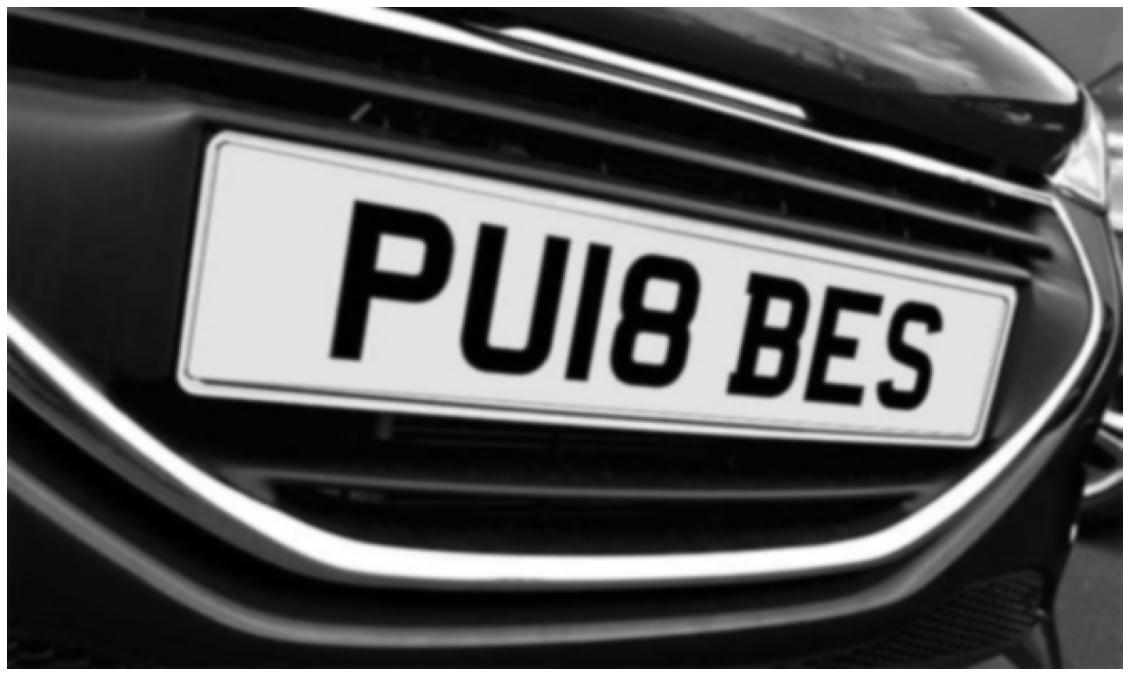

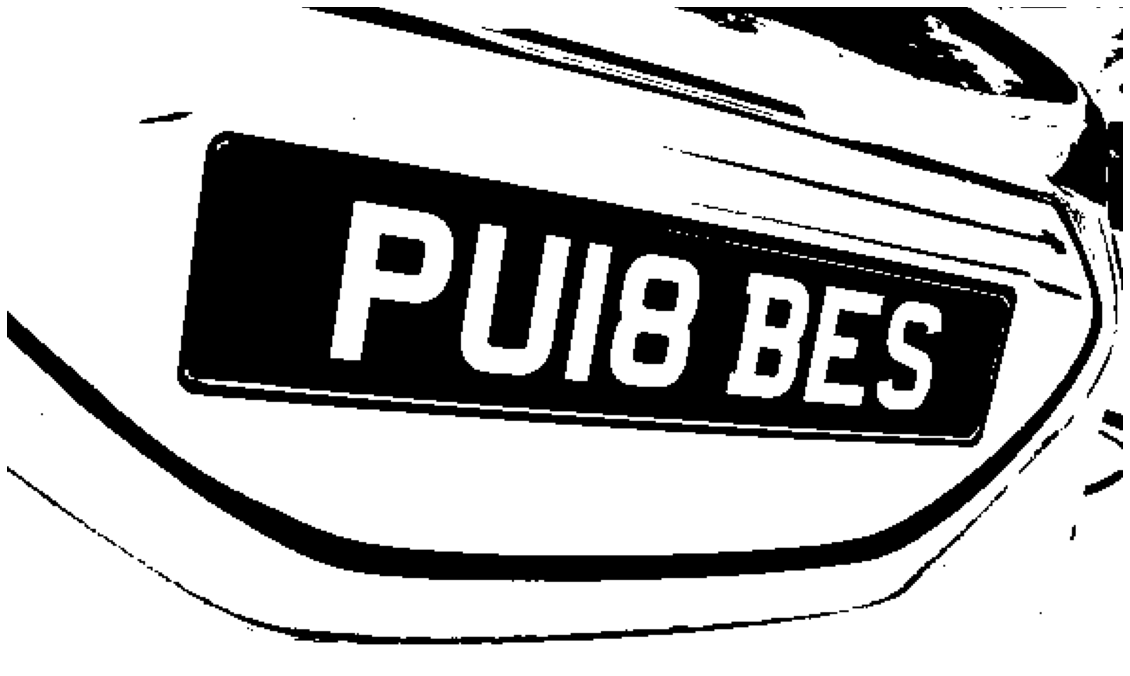

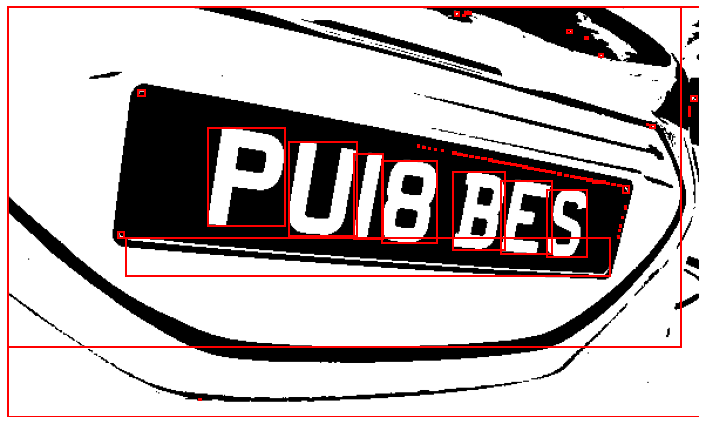

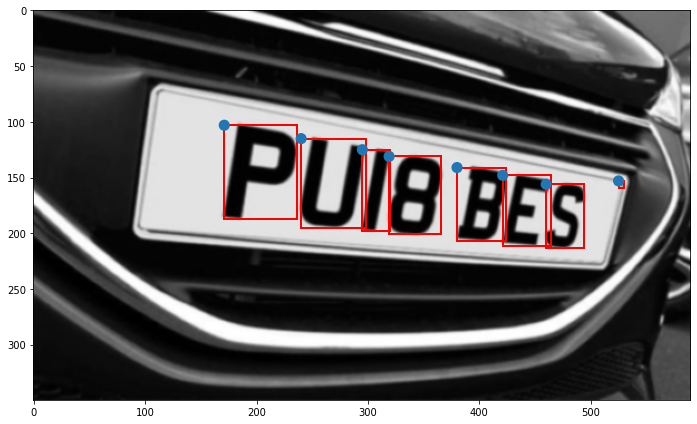

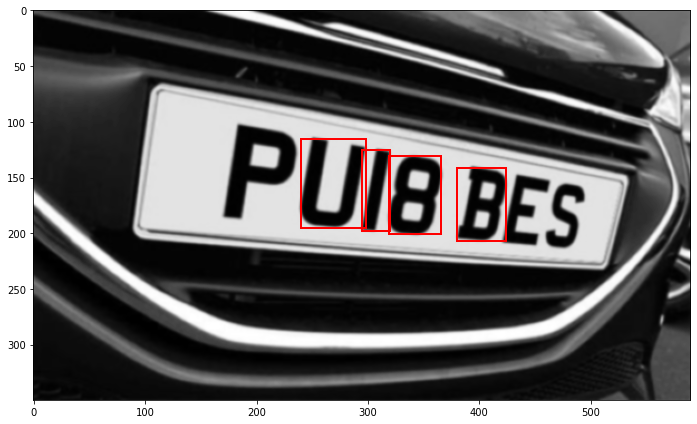

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[]
[]
['8']
['B']


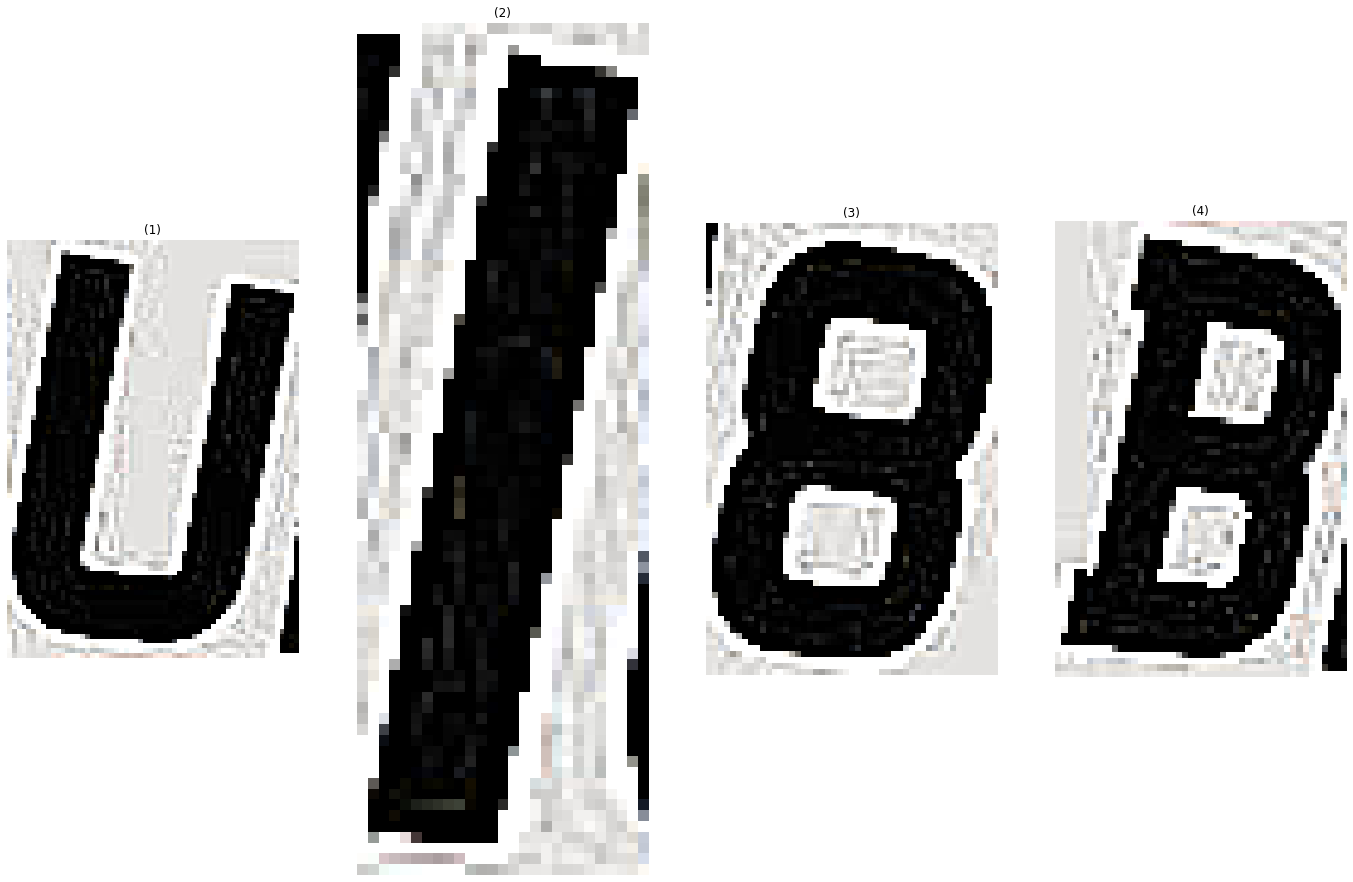

350 590
105 217 230 434


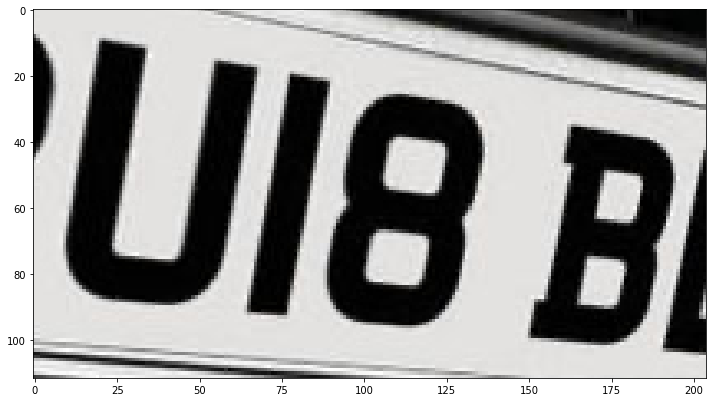

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['Ui8 BZ']


In [1122]:
# 1. 
number = 50
name = f"Cars{number}.png"
car, gray_img, blurred_gray_img = read_img(name)

# 2. 
thresh, binary = get_binary(blurred_gray_img)

# 3.
label_image = connected_comps(binary)

# 4.
all_points = get_probably_text_regions(blurred_gray_img, label_image)

# 5.
best = get_plate_number(all_points, blurred_gray_img)

# 6.
get_data(best, car)

# 7.
full_plate = get_data2(best, car, blurred_gray_img)